In [1]:
import os
import time
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz, stft
from scipy.fft import fft
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve 

In [3]:
def cria_curva_roc_auc(modelo,df_verificacao,df_target):
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(df_target, predictions[:,1]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic REAIS')
    plt.legend(loc="lower right")
    plt.show()
    
def limiar_escore(modelo,df_verificacao,df_target):
    #Imprimindo limiar de Escore
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions[:,1]]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',Precision)
    print('Recall',Recall)
    print('Acuracia',acuracia)
    print('F-Score',F)
    print('Roc-AUC', roc_auc_score(df_target, predictions[:,1]))

# Functions

In [4]:
def plot_eeg(df, name='', save=False):
    fig, rows = plt.subplots(nrows=4, sharex=True, figsize=(17,10))
    fig.patch.set_visible(False)
    fig.tight_layout()

    for ax, col in zip(rows, df.columns):
        ax.plot(df[col])
        ax.title.set_text(col + "_" + name)
        ax.set_ylim(-150, 150)
        ax.patch.set_visible(False)
        
    if not save:
        plt.show()
    else:
        plt.savefig(f'figs/{name}.png')
        plt.close(fig)

In [5]:
def coluniza(a, nome):
    d = pd.DataFrame(a).T
    d.columns = [nome + "_" + str(col) for col in d.columns]
    return d

In [6]:
def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)


def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
folder = '../Data'

In [9]:
%%time
chunks = []
for f in os.listdir(folder):
    print(f)
    if 'Full_Negatives_7nov' in f:
        chunk = pd.read_hdf(os.path.join(folder, f))
        chunks.append(chunk)
neg = pd.concat(chunks, axis=0)

Full_Positives_7nov.hdf
Full_Negatives_7nov0.hdf
Full_Negatives_7nov2.hdf
Full_Negatives_7nov1.hdf
CPU times: user 19 s, sys: 21.3 s, total: 40.3 s
Wall time: 2min 18s


In [10]:
#Esqueci do target 0 rs
neg['Target'] = 0

In [11]:
pos = pd.read_hdf(os.path.join(folder, "Full_Positives_7nov.hdf"))

In [12]:
pos.shape, neg.shape

((1540, 5), (30000, 5))

In [13]:
#junta em um df
df = pd.concat([neg, pos]).reset_index(drop=True)

In [14]:
df['Target'].value_counts(dropna=False)

0    30000
1     1540
Name: Target, dtype: int64

In [15]:
#janelas de crise (alguns bebes tem muito pouco, não são usados para validar)
pos['File'].value_counts()

fabiana_1.edf           646
gilmara_cristina.edf    357
murilo_1.edf            211
remise_jean.edf          94
danila_ramos_4.edf       85
sarah_jadach.edf         84
danila_ramos.edf         56
juliana_lima_1.edf        5
juliana_lima_2.edf        1
marilene.edf              1
Name: File, dtype: int64

In [16]:
#janelas de não crise
df['File'].value_counts()

murilo_1.edf            11234
danila_ramos_5.edf       5550
danila_ramos_4.edf       3755
marilene.edf             2946
remise_jean.edf          2911
juliana_lima_2.edf       1945
fabiana_1.edf            1120
gilmara_cristina.edf      784
danila_ramos.edf          657
juliana_lima_1.edf        503
sarah_jadach.edf           84
danila_ramos_3.edf         51
Name: File, dtype: int64

# Testando em tudo
Sinais de 4 canais, 6000 amostras, frequencia = 200/sec

In [18]:
df['Data'].values[0].columns

Index(['EEG C3-P3', 'EEG C4-P4', 'EEG P3-P4', 'EEG A1-A2'], dtype='object')

In [19]:
dictStftArrayFinal = {}

In [20]:
from tqdm import tqdm

In [21]:
fs = 200 # Hz
n = 5*fs # 5 seg

In [22]:
for bb in tqdm(df['File'].unique()):

    dataArray = None
    targetArray = None
    for i,row in (df[df['File'] == bb].sort_values('timestamp_start').reset_index(drop=True))[['Data','Target']].iterrows():

        if i == 0:

            dataArray = row['Data'].values.copy()

            if row['Target'] == 0:
                targetArray = np.zeros((row['Data'].values.shape[0]))
            else:
                targetArray = np.ones((row['Data'].values.shape[0]))

        else:

            dataArray = np.concatenate((dataArray,row['Data'].values))

            if row['Target'] == 0:
                targetArray = np.concatenate((targetArray,np.zeros((row['Data'].values.shape[0]))))
            else:
                targetArray = np.concatenate((targetArray,np.ones((row['Data'].values.shape[0]))))
                
    Arrays = []
    Targets = []
    # Para cada canal de eeg
    for j in np.arange(0,dataArray.shape[1]):

        array = butter_bandpass_filter(dataArray[:,j], 0.5, 75, fs, order=6)
        subArray = [np.abs(np.fft.rfft(array[i:i + n]))/np.max(np.abs(np.fft.rfft(array[i:i + n]))) for i in range(0, len(array), n) if len(array[i:i + n]) == n]

        if j == 0:
            subTarget = [np.max(targetArray[i:i + n]) for i in range(0, len(targetArray), n) if len(targetArray[i:i + n]) == n]
            Targets.append(subTarget)

        Arrays.append(subArray)

    Arrays = np.array(Arrays).swapaxes(0,1).swapaxes(1,2)
    Targets = np.array(Targets)

    ArrayFinal = []
    TargetFinal = []

    for j in np.arange(3,Arrays.shape[0]):

        ArrayFinal.append(Arrays[j-3:j])
        TargetFinal.append(Targets[0,j-1])

    ArrayFinal = np.array(ArrayFinal)
    TargetFinal= np.array(TargetFinal)

    dictStftArrayFinal[bb] = { 'array' : ArrayFinal, 'target' : TargetFinal }

100%|██████████| 12/12 [2:27:24<00:00, 737.01s/it]  


In [23]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    tgt  = dictStftArrayFinal[bb]['target']
    
    target = []
    
    for i in tgt:
        if i == 0:
            target.append([0,1])
        else:
            target.append([1,0])
            
    tgt = np.array(target)
    
    dictStftArrayFinal[bb]['target'] = tgt
    
    dictStftArrayFinal[bb]['array'] = dictStftArrayFinal[bb]['array'].swapaxes(1,2).swapaxes(2,3)

In [24]:
save_to_file(dictStftArrayFinal, 'dictStftArrayFinal.pkl')

In [25]:
! ls -lah

total 8.5G
drwxr-xr-x 3 jupyter jupyter 4.0K Dec  5 16:50 .
drwxr-xr-x 8 jupyter jupyter 4.0K Dec  5 14:12 ..
-rw-r--r-- 1 jupyter jupyter 8.5G Dec  5 16:50 dictStftArrayFinal.pkl
drwxr-xr-x 2 jupyter jupyter 4.0K Dec  5 14:14 .ipynb_checkpoints
-rw-r--r-- 1 jupyter jupyter  27K Dec  5 16:50 ML Pipe Feat Eng p Vini 3x5s.ipynb


## Model

In [26]:
del df, neg, pos

In [27]:
del dataArray, ArrayFinal, TargetFinal, array, subArray, subTarget, targetArray

In [28]:
import gc
gc.collect()

110

# Neural Network

In [29]:
dictStftArrayFinal.keys()

dict_keys(['danila_ramos.edf', 'danila_ramos_3.edf', 'danila_ramos_4.edf', 'danila_ramos_5.edf', 'fabiana_1.edf', 'murilo_1.edf', 'remise_jean.edf', 'gilmara_cristina.edf', 'juliana_lima_1.edf', 'juliana_lima_2.edf', 'marilene.edf', 'sarah_jadach.edf'])

# Treino em Todos Menos  "murilo_1.edf"

In [30]:
tgt = None
stftArrayFinal = None

In [31]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    if bb != 'murilo_1.edf':
    
        if i == 0:
            
            tgt = dictStftArrayFinal[bb]['target'].copy()
            stftArrayFinal = dictStftArrayFinal[bb]['array'].copy()
            
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal, dictStftArrayFinal[bb]['array']))
            tgt = np.concatenate((tgt, dictStftArrayFinal[bb]['target']))

In [32]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(121803, 501, 4, 3)

In [33]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 256
epochs = 300 #600
input_shape,num_classes

((501, 4, 3), 2)

In [34]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*5, kernel_size=(4,1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(4,1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*10, kernel_size=(4,4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [35]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 501, 4, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 249, 4, 160)       2080      
_________________________________________________________________
activation (Activation)      (None, 249, 4, 160)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 62, 4, 160)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 4, 160)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 1, 320)        819520    
_________________________________________________________________
activation_1 (Activation)    (None, 59, 1, 320)       

In [36]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=[ 'AUC'])

In [37]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave_murilo.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal, tgt,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(dictStftArrayFinal['murilo_1.edf']['array'], dictStftArrayFinal['murilo_1.edf']['target']),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

Epoch 1/300
476/476 [==============================] - 106s 223ms/step - loss: 0.3029 - auc: 0.9482 - val_loss: 0.0708 - val_auc: 0.9971
Epoch 2/300
476/476 [==============================] - 105s 220ms/step - loss: 0.0932 - auc: 0.9935 - val_loss: 0.0937 - val_auc: 0.9914
Epoch 3/300
476/476 [==============================] - 105s 221ms/step - loss: 0.0688 - auc: 0.9961 - val_loss: 0.0593 - val_auc: 0.9958
Epoch 4/300
476/476 [==============================] - 105s 220ms/step - loss: 0.0576 - auc: 0.9972 - val_loss: 0.0908 - val_auc: 0.9919
Epoch 5/300
476/476 [==============================] - 104s 219ms/step - loss: 0.0510 - auc: 0.9978 - val_loss: 0.1247 - val_auc: 0.9878
Epoch 6/300
476/476 [==============================] - 104s 219ms/step - loss: 0.0446 - auc: 0.9981 - val_loss: 0.1029 - val_auc: 0.9900
Epoch 7/300
476/476 [==============================] - 104s 219ms/step - loss: 0.0387 - auc: 0.9985 - val_loss: 0.2124 - val_auc: 0.9733
Epoch 8/300
476/476 [====================

In [38]:
model.save_weights("./modelo_murilo.hdf5")

In [39]:
model.load_weights('./bestAutoSave_murilo.hdf5')

In [25]:
gc.collect()

4257

In [30]:
indexes = list(pd.DataFrame(dictStftArrayFinal['murilo_1.edf']['target']).sample(frac=0.5).index)

In [31]:
y_pred = model.predict(dictStftArrayFinal['murilo_1.edf']['array'][indexes,:,:,:])

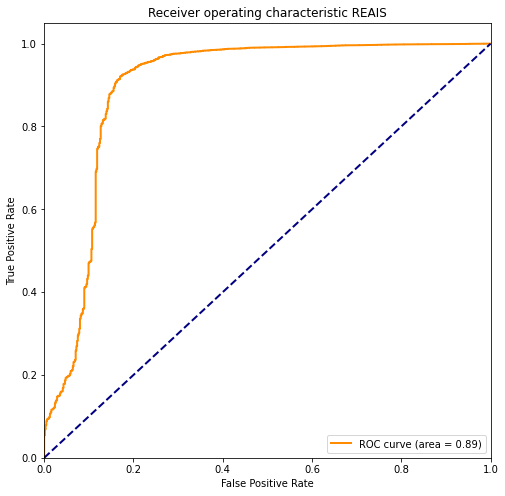

In [32]:
cria_curva_roc_auc(model,dictStftArrayFinal['murilo_1.edf']['array'][indexes,:,:,:],dictStftArrayFinal['murilo_1.edf']['target'][indexes,1])

In [33]:
limiar_escore(model,dictStftArrayFinal['murilo_1.edf']['array'][indexes,:,:,:],dictStftArrayFinal['murilo_1.edf']['target'][indexes,1])

Limiar que maxima especificidade e sensitividade:
[0.9857518076896667]
Precision 0.9968810233047135
Recall 0.8600193493771919
Acuracia 0.8599703264094956
F-Score 0.9234065345474023
Roc-AUC 0.8944608386358069


In [35]:
confusion_matrix(dictStftArrayFinal['murilo_1.edf']['target'][indexes,1], [1 if x >= 0.1 else 0 for x in y_pred[:,1]])

array([[   80,   544],
       [   43, 33033]])

# Treino em Todos Menos  "remise_jean.edf"

In [36]:
tgt = None
stftArrayFinal = None

In [37]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    if bb != 'remise_jean.edf':
    
        if i == 0:
            
            tgt = dictStftArrayFinal[bb]['target'].copy()
            stftArrayFinal = dictStftArrayFinal[bb]['array'].copy()
            
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal, dictStftArrayFinal[bb]['array']))
            tgt = np.concatenate((tgt, dictStftArrayFinal[bb]['target']))

In [38]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(171741, 501, 4, 3)

In [39]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 256
epochs = 300 #600
input_shape,num_classes

((501, 4, 3), 2)

In [40]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*5, kernel_size=(4,1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(4,1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*10, kernel_size=(4,4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [41]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 501, 4, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 249, 4, 160)       2080      
_________________________________________________________________
activation_2 (Activation)    (None, 249, 4, 160)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 62, 4, 160)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 4, 160)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 1, 320)        819520    
_________________________________________________________________
activation_3 (Activation)    (None, 59, 1, 320)       

In [42]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['AUC'])

In [43]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave_remise.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal, tgt,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(dictStftArrayFinal['remise_jean.edf']['array'], dictStftArrayFinal['remise_jean.edf']['target']),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

Epoch 1/300
671/671 [==============================] - 116s 173ms/step - loss: 0.2393 - auc: 0.9678 - val_loss: 0.6284 - val_auc: 0.7779
Epoch 2/300
671/671 [==============================] - 114s 170ms/step - loss: 0.0525 - auc: 0.9976 - val_loss: 0.8673 - val_auc: 0.5465
Epoch 3/300
671/671 [==============================] - 114s 169ms/step - loss: 0.0411 - auc: 0.9985 - val_loss: 1.0733 - val_auc: 0.4279
Epoch 4/300
671/671 [==============================] - 113s 169ms/step - loss: 0.0358 - auc: 0.9988 - val_loss: 0.7426 - val_auc: 0.6662
Epoch 5/300
671/671 [==============================] - 114s 169ms/step - loss: 0.0318 - auc: 0.9990 - val_loss: 1.6133 - val_auc: 0.3533
Epoch 6/300
671/671 [==============================] - 113s 169ms/step - loss: 0.0305 - auc: 0.9990 - val_loss: 1.7677 - val_auc: 0.2860


In [44]:
model.save_weights("./modelo_remise.hdf5")

In [45]:
model.load_weights('./bestAutoSave_remise.hdf5')

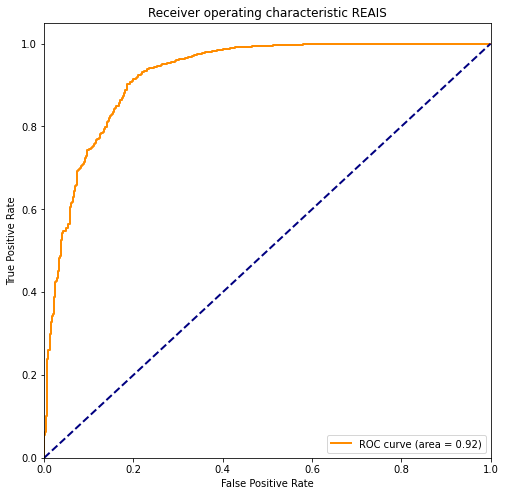

In [46]:
cria_curva_roc_auc(model,dictStftArrayFinal['remise_jean.edf']['array'],dictStftArrayFinal['remise_jean.edf']['target'][:,1])

In [47]:
limiar_escore(model,dictStftArrayFinal['remise_jean.edf']['array'],dictStftArrayFinal['remise_jean.edf']['target'][:,1])

Limiar que maxima especificidade e sensitividade:
[0.2567901909351349]
Precision 0.993785350185043
Recall 0.8421800106515178
Acuracia 0.8421806104334879
F-Score 0.9117232543241511
Roc-AUC 0.9246459671330588


In [48]:
y_pred = model.predict(dictStftArrayFinal['remise_jean.edf']['array'])

In [49]:
confusion_matrix(dictStftArrayFinal['remise_jean.edf']['target'][:,1], [1 if x >= 0.08519119024276733 else 0 for x in y_pred[:,1]])

array([[  416,   148],
       [  885, 16014]])

In [50]:
pd.DataFrame(dictStftArrayFinal['remise_jean.edf']['target'])[1].value_counts()

1    16899
0      564
Name: 1, dtype: int64

FIM